<a href="https://colab.research.google.com/github/microprediction/microprediction/blob/master/notebook_examples_blog/Vaccination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [198]:
from scipy.special import lambertw 
from scipy.stats import norm
from scipy.integrate import quadrature
r = 1.3
import math
import numpy as np


In [199]:
from microconventions.stats_conventions import StatsConventions


In [200]:
def eventual(r,s=1):
  return 1+np.real(lambertw(-s*r*math.exp(-r))/r)

In [201]:
eventual(4.1)

0.9821704646039714

In [105]:
def normpdf(x,mu,sigma):
    return 1/sigma*norm.pdf((x-mu)/sigma)
np.sum([ normpdf(x,mu=0,sigma=5) for x in np.linspace(-20,20,40*1000)])/1000

0.9999116858623723

In [126]:
def avg_eventual(r,s=1,sigma=1.0):
   def rtimes(u):
      return [normpdf(x=u_,mu=r,sigma=sigma)*eventual(u_) for u_ in u]
   return quadrature(rtimes, a=max(1,r-3*sigma), b=r+3*sigma)[0]


In [127]:
avg_eventual(r=1.5,sigma=2)

0.47758736075406694

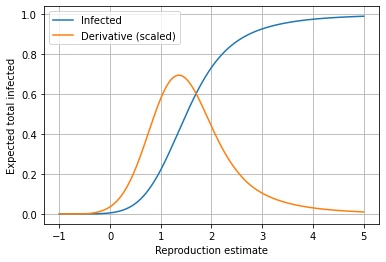

In [137]:
xs = np.linspace(-1.0,5.0,500)
ys = [avg_eventual(x,sigma=0.5) for x in xs]
import matplotlib.pyplot as plt
gradient = [dx*100 for dx in [0]+list(np.diff(ys))]
plt.plot(xs,ys,xs,gradient)
plt.xlabel('Reproduction estimate')
plt.ylabel('Expected total infected')
plt.legend(['Infected','Derivative (scaled)'])
plt.grid()


In [ ]:
!pip install shgo

In [230]:
# Intervention optimization example 
# We can reason as to what the solution will look like in advance but let's
# debug our thoughts. 

n = 6
T = 6 # Intervention budget
ri = np.linspace(2,5,n) # Initial r value observations (with errors)
def f(xs):
   """ 
       xs: vector of interventions, len n
   """
   over = np.sum(xs)-T 
   penalty = over*over
   xi = [ r-x for r,x in zip(list(ri),list(xs)) ]
   return np.sum([ avg_eventual(r=xi_,s=1,sigma=0.5) for xi_ in xi])+penalty
   
bounds = [(0, 4.0),]*n

In [231]:
f(np.array([1,1,1,1]))

6.475524955453402

In [232]:
from shgo import shgo
res = shgo(f, bounds, n=50, iters=5)

In [226]:
res

     fun: 2.3533268016920266
    funl: array([2.3533268, 2.3533268])
 message: 'Optimization terminated successfully.'
    nfev: 385
     nit: 5
   nlfev: 129
   nlhev: 0
   nljev: 21
 success: True
    tnev: 379
       x: array([1.10634530e+00, 2.10634533e+00, 1.66533454e-16, 1.11022302e-16])
      xl: array([[1.10634530e+00, 2.10634533e+00, 1.66533454e-16, 1.11022302e-16],
       [1.10634441e+00, 2.10634604e+00, 1.14087598e-14, 0.00000000e+00]])

In [233]:
res.x # interventions

array([1.43732117, 2.03732113, 2.63732111, 0.        , 0.        ,
       0.        ])

In [251]:
xt = [ i-xi for i,xi in zip(ri,res.x)] # terminal positions
xt

[0.562678829107089, 0.5626788685698978, 0.5626788861423155, 3.8, 4.4, 5.0]

In [246]:
f(res.x)

3.1480212194521524

Text(0, 0.5, 'Total sufferers')

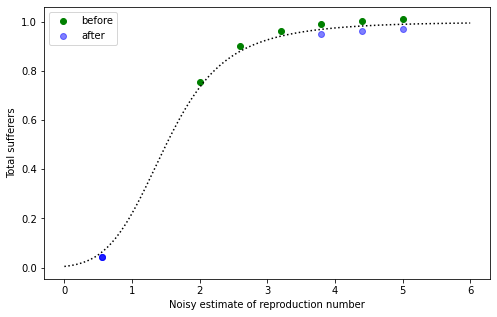

In [287]:
plt.rcParams["figure.figsize"] = (8,5)
yt = [ avg_eventual(r=x,s=1,sigma=0.5)-0.02 for x in xt ]
yi = [ avg_eventual(r=x,s=1,sigma=0.5)+0.02 for x in ri ]
plt.scatter(ri,yi,c='g')
plt.scatter(xt,yt,alpha=0.5,c='b')
plt.legend(['before','after'])
_x = np.linspace(0,6,200)
_y = [ avg_eventual(r=_xi,sigma=0.5) for _xi in _x]
plt.plot(_x,_y,':k')
plt.xlabel('Noisy estimate of reproduction number')
plt.ylabel('Total sufferers')
